In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline

In [3]:
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


In [4]:
# set random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [5]:
# sampling function for vae, the sampling result is the input for decoder of vae
# sampling is based on so-called "reparameterization trick"
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
# load the mnist full data set and one-hot encoding for labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y_train_onehot = onehot.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot.fit_transform(y_test.reshape(-1, 1))

In [7]:
image_size = x_train.shape[1]
original_dim = image_size * image_size

# make sure the input image is flattened and pixel values in image is between 0 and 1
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype("float32") /255
x_test = x_test.astype("float32") /255

In [8]:
input_shape = (original_dim, )
batch_size = 32
# choose the latent variable dimension as 2, so the results can be easily visualized
# higher latent variable dimensionality might give better prediction results
latent_dim = 2
epochs = 20

In [9]:
from keras import Model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse
from keras.optimizers import Adam

In [10]:
# encoder
inputs = Input(shape=input_shape, name="encoder_input")

x = Dense(512, activation="relu")(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [11]:
import tensorflow as tf
from keras.layers import Activation

In [12]:
# classifier
# the classifier is based on the one of the outputs from the encoder of the vae
# the z_mean is the input for the classifier, 
# which means that the z_mean from vae encoder is the learned representation for prediction
classifier_hidden_num = 10
classifier_input = Input(shape=(latent_dim,), name = "classifier_input")

x = Dense(classifier_hidden_num, activation="relu")(classifier_input)
x = Dense(classifier_hidden_num*2, activation="relu")(x)
x = Dense(10)(x)
classifier_output = Activation(tf.nn.softmax, name="classifier")(x)

In [13]:
classifier = Model(classifier_input, classifier_output)
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
classifier (Activation)      (None, 10)                0         
Total params: 460
Trainable params: 460
Non-trainable params: 0
_________________________________________________________________


In [14]:
# decoder
# decoder takes the sampling from the vae encoder generated distributioin,(gaussian with z_mean and np.exp(log_z_var))
# and reconstruct the input image
latent_inputs = Input(shape=(latent_dim,))
x = Dense(512, activation="relu")(latent_inputs)
vae_output = Dense(original_dim, activation="sigmoid", name="vae")(x)

decoder = Model(latent_inputs, vae_output)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1536      
_________________________________________________________________
vae (Dense)                  (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [15]:
# here the input of the classifier and the input of the decoder is specified
classifier_output = classifier(encoder(inputs)[0])
vae_output = decoder(encoder(inputs)[2])

vae_classifier = Model(inputs, [classifier_output, vae_output])
vae_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           460         model_1[1][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 784)          403728      model_1[2][2]                    
Total para

In [16]:
from keras.losses import categorical_crossentropy

In [17]:
def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(inputs, vae_output)
    rebuilt_reconstruction_loss = reconstruction_loss * original_dim

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis = -1)
    kl_loss *= -0.5
    vae_loss = K.mean(kl_loss + rebuilt_reconstruction_loss)
    return vae_loss

In [18]:
opt = Adam(lr=0.0005)
# here the loss weights are 1:1, which means that there is no penalty for misclassification
# the total loss =  1* vae_loss + 1* classification_loss
vae_classifier.compile(optimizer=opt, loss={"model_2":"categorical_crossentropy", "model_3":vae_loss},
                       metrics={'model_2': 'accuracy'},
                      loss_weights = {"model_2":1, "model_3":1})

In [19]:
vae_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           460         model_1[1][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 784)          403728      model_1[2][2]                    
Total para

In [20]:
history = vae_classifier.fit(x_train, {'model_2': y_train_onehot, 'model_3': x_train}, epochs=epochs, batch_size=batch_size, 
                 validation_data = [x_test, {'model_2': y_test_onehot, 'model_3': x_test}])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 363us/step - loss: 50.1988 - model_2_loss: 1.6431 - model_3_loss: 48.5556 - model_2_acc: 0.3867 - val_loss: 44.7804 - val_model_2_loss: 1.1935 - val_model_3_loss: 43.5869 - val_model_2_acc: 0.5390
Epoch 2/20
60000/60000 [==============================] - 21s 342us/step - loss: 44.2357 - model_2_loss: 1.1299 - model_3_loss: 43.1059 - model_2_acc: 0.5630 - val_loss: 43.3526 - val_model_2_loss: 1.0386 - val_model_3_loss: 42.3139 - val_model_2_acc: 0.6199
Epoch 3/20
60000/60000 [==============================] - 21s 343us/step - loss: 42.9280 - model_2_loss: 0.9533 - model_3_loss: 41.9748 - model_2_acc: 0.6532 - val_loss: 42.1397 - val_model_2_loss: 0.8618 - val_model_3_loss: 41.2779 - val_model_2_acc: 0.6983
Epoch 4/20
60000/60000 [==============================] - 21s 346us/step - loss: 41.8736 - model_2_loss: 0.8162 - model_3_loss: 41.0575 - model_2_acc: 0.7183 - val_loss: 41.

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

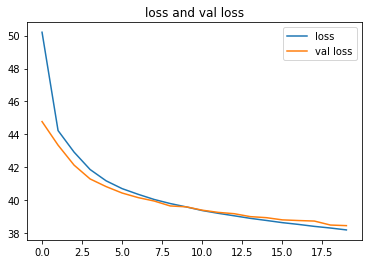

In [22]:
plt.title("loss and val loss")
plt.plot(loss, label = "loss")
plt.plot(val_loss, label = "val loss")
plt.legend()

In [23]:
# 2d plot based on the samplings
def vae_z_2dplot(x_data, y_data, encoder):
    _, _, z = encoder.predict(x_data)
    plt.figure(figsize=(15,15))
    plt.title("latent space plot")
    plt.xlabel("z_one")
    plt.ylabel("y_two")
    plt.scatter(z[:,0], z[:,1], c = y_data, alpha = 0.5, s = 10)
    plt.colorbar()

In [24]:
# 2d plot based on the z_mean of the encoder, the learned representation
def vae_zmean_2dplot(x_data, y_data, encoder):
    z_mean, _, _ = encoder.predict(x_data)
    plt.figure(figsize=(15,15))
    plt.title("latent space plot")
    plt.xlabel("z_one")
    plt.ylabel("y_two")
    plt.scatter(z_mean[:,0], z_mean[:,1], c = y_data, alpha = 0.5, s = 10)
    plt.colorbar()

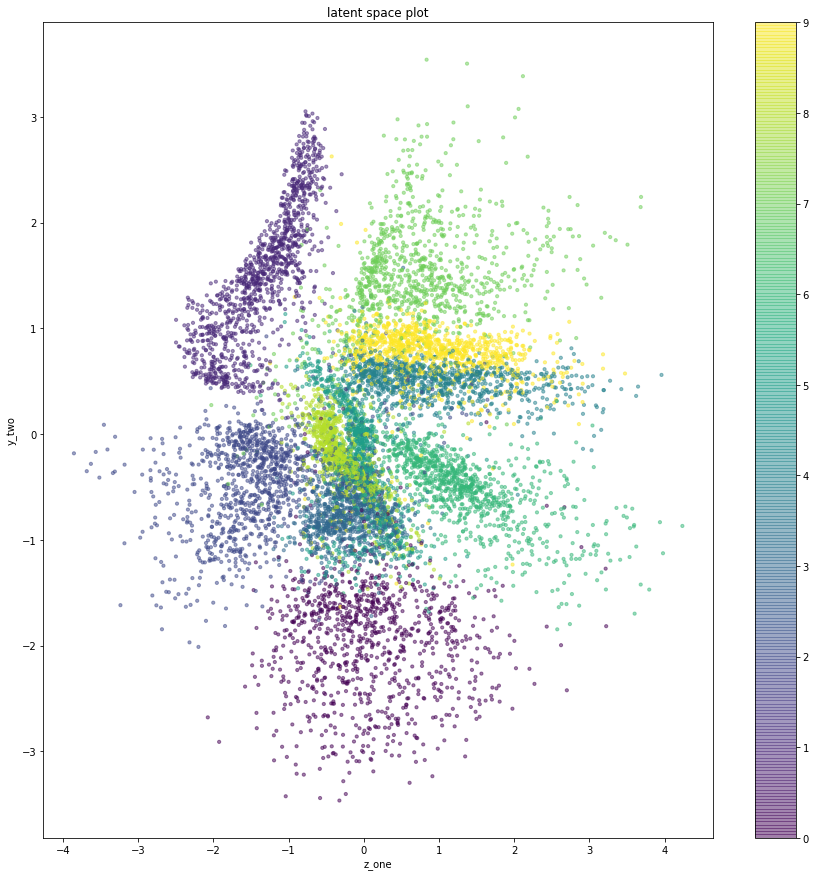

In [25]:
vae_zmean_2dplot(x_test, y_test, encoder)

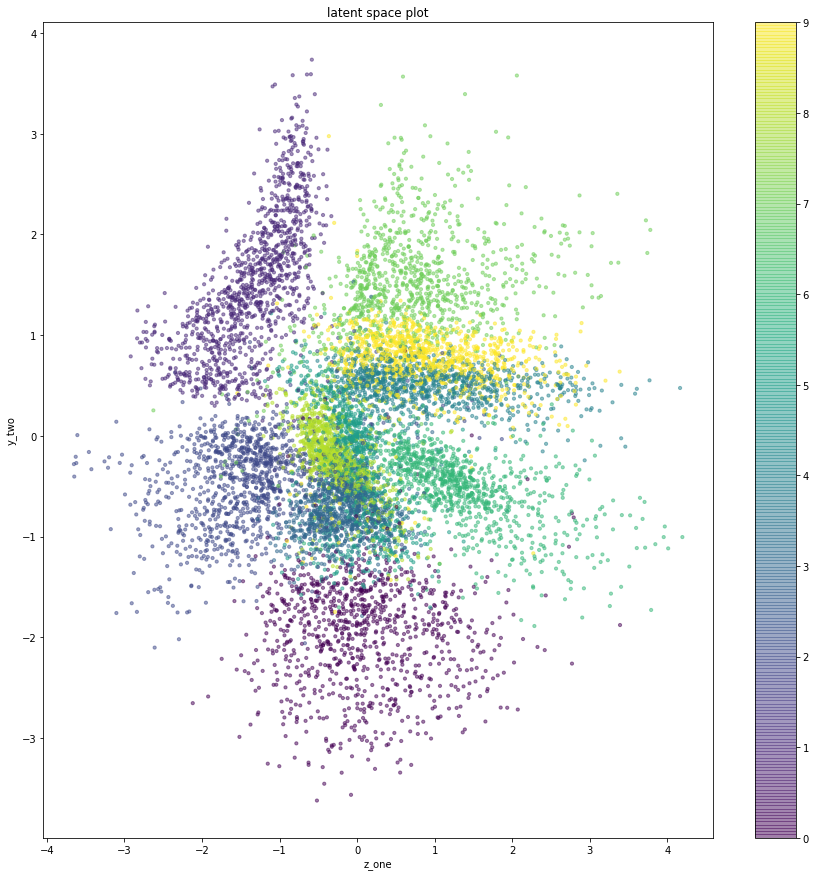

In [26]:
vae_z_2dplot(x_test, y_test, encoder)

the plot of z_mean doesn't differ a lot from the plot of z. Actually quite similar cloud points.

In [27]:
# this function samples points from learned representation space as input 
# and gives it to the decoder, the decoder generates new images based on the sampled points.
# the sample interval of x-axis is [-4, 4], the sample interval of y-axis is [-4, 4].
# the number of samples is decided by num_z_one, num_z_two. the total number is n_z_one * n_z_two
# the title of each subplot is the sampling point coordinate
def vaedecode_result_2dplot(num_z_one, num_z_two, z_one_linspace, z_two_linspace, decoder):
    fig, axes = plt.subplots(num_z_two, num_z_one, figsize= (10,10))
    for z_two_index in range(num_z_two):
        for z_one_index in range(num_z_one):
            z_two = z_two_linspace[z_two_index]
            z_one = z_one_linspace[z_one_index]
            z_sample = np.array([[z_one, z_two]])
            
            result = decoder.predict(z_sample)
            result_img = result.reshape(image_size, image_size)
            
            axes[z_two_index, z_one_index].set_axis_off()
            axes[z_two_index, z_one_index].set_title(
                str(np.around(z_one, decimals=1)) + ", " + str(np.around(z_two, decimals=1))
            )
            axes[z_two_index, z_one_index].imshow(result_img, cmap="gray")

In [28]:
z_one_interval = [-4, 4]
z_two_interval = [-4, 4]
num_z_one = 10
num_z_two = 10

z_one_linspace = np.linspace(z_one_interval[0], z_one_interval[1], num_z_one)
z_two_linspace = (np.linspace(z_two_interval[0], z_two_interval[1], num_z_two))[::-1]

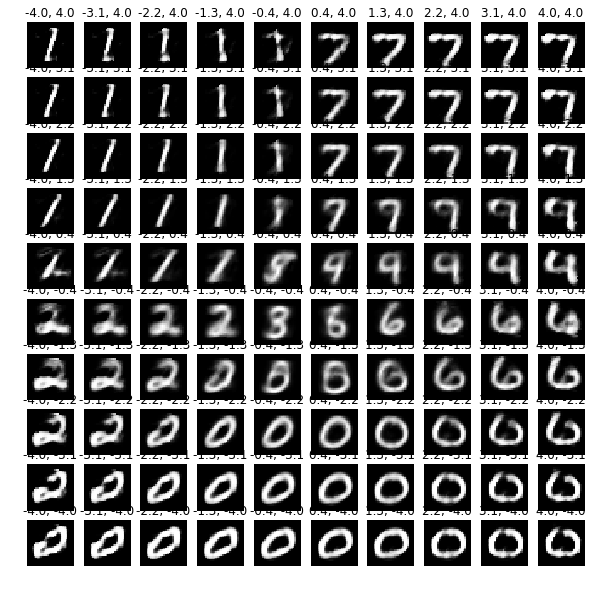

In [29]:
vaedecode_result_2dplot(num_z_one, num_z_two, z_one_linspace, z_two_linspace, decoder)

the generated number distributions follow the z point cloud. For example, numbers on the left top are mostly ones, or looks like one, which cooresponds the the point cloud. The numbers in the middle are not so distinguishable. In the z point cloud, the corresponding middle are mixed with points of different digits.

The accuracy of the classifier is around 81%, which is not so good. So in next experiment, larger penalty for the misclassification is added.

reinitialize the vae based classifier, larger penalty for the misclassification in compile part

In [30]:
# encoder
inputs = Input(shape=input_shape, name="encoder_input")

x = Dense(512, activation="relu")(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])

# classifier
# the classifier is based on the one of the outputs from the encoder of the vae
# the z_mean is the input for the classifier, 
# which means that the z_mean from vae encoder is the learned representation for prediction
classifier_hidden_num = 10
classifier_input = Input(shape=(latent_dim,), name = "classifier_input")
x = Dense(classifier_hidden_num, activation="relu")(classifier_input)
x = Dense(classifier_hidden_num*2, activation="relu")(x)
x = Dense(10)(x)
classifier_output = Activation(tf.nn.softmax, name="classifier")(x)
classifier = Model(classifier_input, classifier_output)

# decoder
# decoder takes the sampling from the vae encoder generated distributioin,(gaussian with z_mean and np.exp(log_z_var))
# and reconstruct the input image
latent_inputs = Input(shape=(latent_dim,))
x = Dense(512, activation="relu")(latent_inputs)
vae_output = Dense(original_dim, activation="sigmoid", name="vae")(x)

decoder = Model(latent_inputs, vae_output)

# here the input of the classifier and the input of the decoder is specified
classifier_output = classifier(encoder(inputs)[0])
vae_output = decoder(encoder(inputs)[2])

vae_classifier = Model(inputs, [classifier_output, vae_output])
vae_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
model_5 (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
model_6 (Model)                 (None, 10)           460         model_5[1][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 784)          403728      model_5[2][2]                    
Total para

In [32]:
opt = Adam(lr=0.0005)
# now change the penalty to a larger value.
# the total loss =  1* vae_loss + 4* classification_loss
vae_classifier.compile(optimizer=opt, loss={"model_6":"categorical_crossentropy", "model_7":vae_loss},
                       metrics={'model_6': 'accuracy'},
                      loss_weights = {"model_6":4, "model_7":1})

In [33]:
history = vae_classifier.fit(x_train, {"model_6": y_train_onehot, "model_7": x_train}, epochs=epochs, batch_size=batch_size, 
                 validation_data = [x_test, {"model_6": y_test_onehot, "model_7": x_test}])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 365us/step - loss: 53.9582 - model_6_loss: 1.3649 - model_7_loss: 48.4986 - model_6_acc: 0.4877 - val_loss: 47.0205 - val_model_6_loss: 0.8387 - val_model_7_loss: 43.6658 - val_model_6_acc: 0.7200
Epoch 2/20
60000/60000 [==============================] - 22s 366us/step - loss: 45.9398 - model_6_loss: 0.6680 - model_7_loss: 43.2680 - model_6_acc: 0.7946 - val_loss: 44.9069 - val_model_6_loss: 0.5522 - val_model_7_loss: 42.6981 - val_model_6_acc: 0.8423
Epoch 3/20
60000/60000 [==============================] - 22s 363us/step - loss: 44.4315 - model_6_loss: 0.4808 - model_7_loss: 42.5085 - model_6_acc: 0.8621 - val_loss: 43.8623 - val_model_6_loss: 0.4588 - val_model_7_loss: 42.0273 - val_model_6_acc: 0.8753
Epoch 4/20
60000/60000 [==============================] - 21s 357us/step - loss: 43.4712 - model_6_loss: 0.3888 - model_7_loss: 41.9162 - model_6_acc: 0.8922 - val_loss: 43.

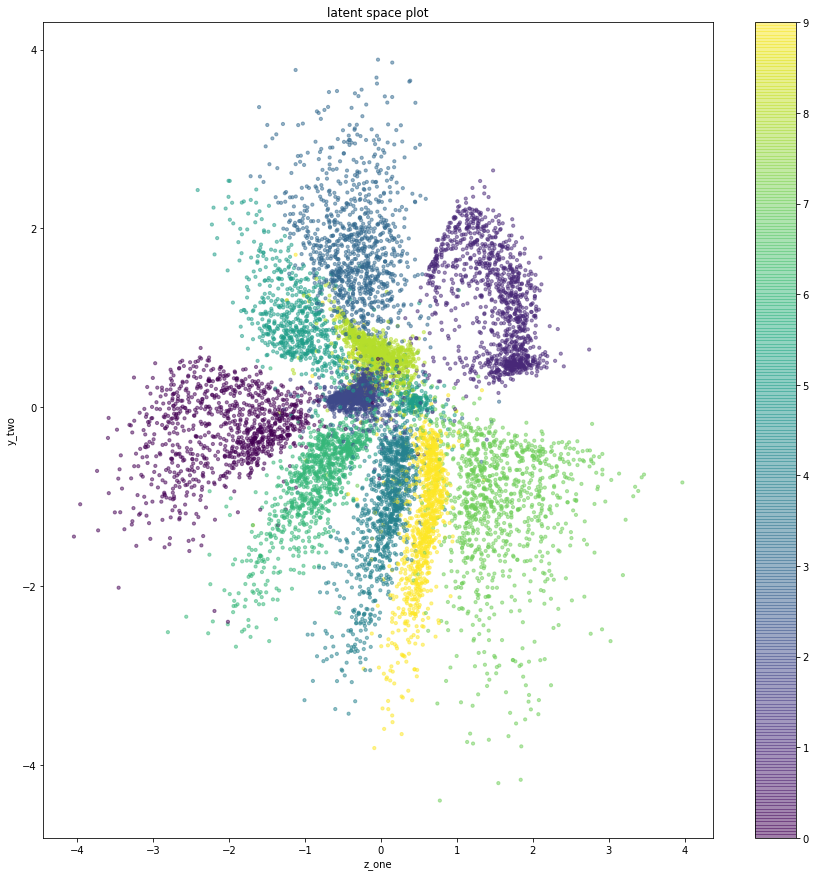

In [34]:
vae_zmean_2dplot(x_test, y_test, encoder)

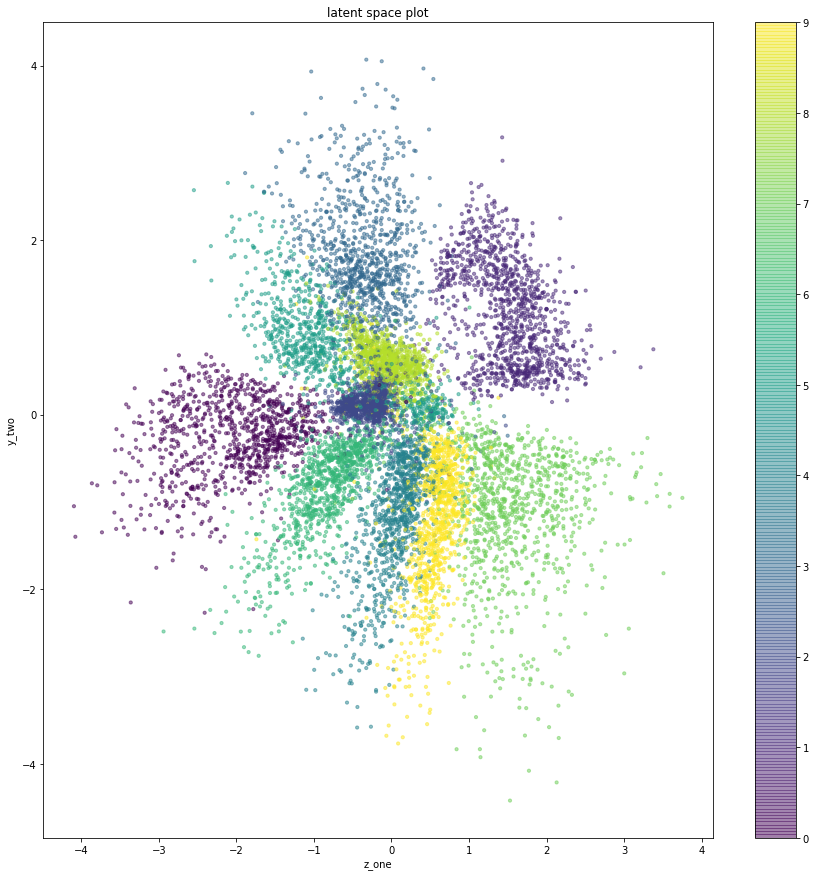

In [35]:
vae_z_2dplot(x_test, y_test, encoder)

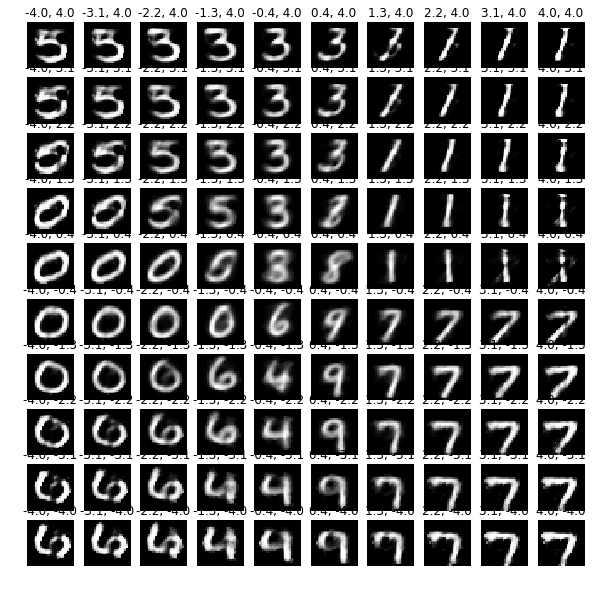

In [36]:
vaedecode_result_2dplot(num_z_one, num_z_two, z_one_linspace, z_two_linspace, decoder)

based on the plots above, apparently =, if we put large penalty on the misclassification, then the variational autoencoder will try to put number of the same digit together (clustering).

So let's try even a very large penalty and see what will happen

In [37]:
# encoder
inputs = Input(shape=input_shape, name="encoder_input")

x = Dense(512, activation="relu")(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])

# classifier
# the classifier is based on the one of the outputs from the encoder of the vae
# the z_mean is the input for the classifier, 
# which means that the z_mean from vae encoder is the learned representation for prediction
classifier_hidden_num = 10
classifier_input = Input(shape=(latent_dim,), name = "classifier_input")
x = Dense(classifier_hidden_num, activation="relu")(classifier_input)
x = Dense(classifier_hidden_num*2, activation="relu")(x)
x = Dense(10)(x)
classifier_output = Activation(tf.nn.softmax, name="classifier")(x)
classifier = Model(classifier_input, classifier_output)

# decoder
# decoder takes the sampling from the vae encoder generated distributioin,(gaussian with z_mean and np.exp(log_z_var))
# and reconstruct the input image
latent_inputs = Input(shape=(latent_dim,))
x = Dense(512, activation="relu")(latent_inputs)
vae_output = Dense(original_dim, activation="sigmoid", name="vae")(x)

decoder = Model(latent_inputs, vae_output)

# here the input of the classifier and the input of the decoder is specified
classifier_output = classifier(encoder(inputs)[0])
vae_output = decoder(encoder(inputs)[2])

vae_classifier = Model(inputs, [classifier_output, vae_output])
vae_classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
model_9 (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
model_10 (Model)                (None, 10)           460         model_9[1][0]                    
__________________________________________________________________________________________________
model_11 (Model)                (None, 784)          403728      model_9[2][2]                    
Total para

In [39]:
opt = Adam(lr=0.0005)
# now change the penalty to a larger value.
# the total loss =  1* vae_loss + 4* classification_loss
vae_classifier.compile(optimizer=opt, loss={"model_10":"categorical_crossentropy", "model_11":vae_loss},
                       metrics={'model_10': 'accuracy'},
                      loss_weights = {"model_10":14, "model_11":1})

In [40]:
history = vae_classifier.fit(x_train, {"model_10": y_train_onehot, "model_11": x_train}, epochs=epochs, batch_size=batch_size, 
                 validation_data = [x_test, {"model_10": y_test_onehot, "model_11": x_test}])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 22s 363us/step - loss: 65.2262 - model_10_loss: 1.0768 - model_11_loss: 50.1514 - model_10_acc: 0.6037 - val_loss: 53.0148 - val_model_10_loss: 0.5038 - val_model_11_loss: 45.9612 - val_model_10_acc: 0.8626
Epoch 2/20
60000/60000 [==============================] - 21s 348us/step - loss: 50.4902 - model_10_loss: 0.3561 - model_11_loss: 45.5054 - model_10_acc: 0.9098 - val_loss: 48.7915 - val_model_10_loss: 0.2997 - val_model_11_loss: 44.5959 - val_model_10_acc: 0.9260
Epoch 3/20
60000/60000 [==============================] - 21s 352us/step - loss: 47.4526 - model_10_loss: 0.2179 - model_11_loss: 44.4023 - model_10_acc: 0.9457 - val_loss: 47.3263 - val_model_10_loss: 0.2615 - val_model_11_loss: 43.6651 - val_model_10_acc: 0.9362
Epoch 4/20
60000/60000 [==============================] - 22s 359us/step - loss: 45.9586 - model_10_loss: 0.1674 - model_11_loss: 43.6153 - model_10_acc: 0

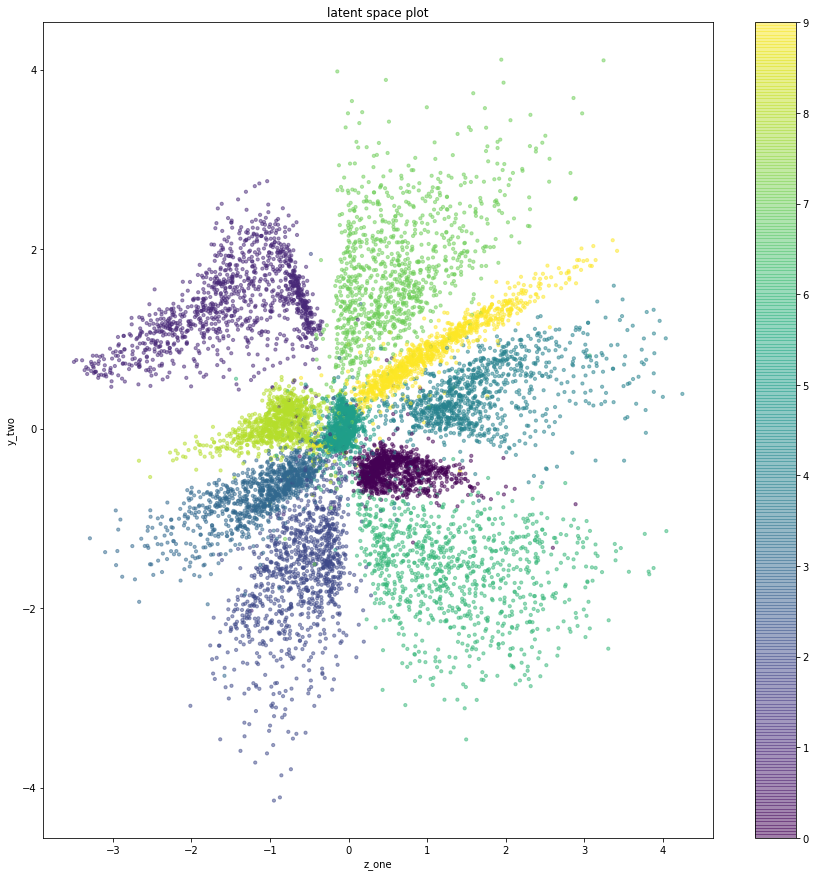

In [41]:
vae_zmean_2dplot(x_test, y_test, encoder)

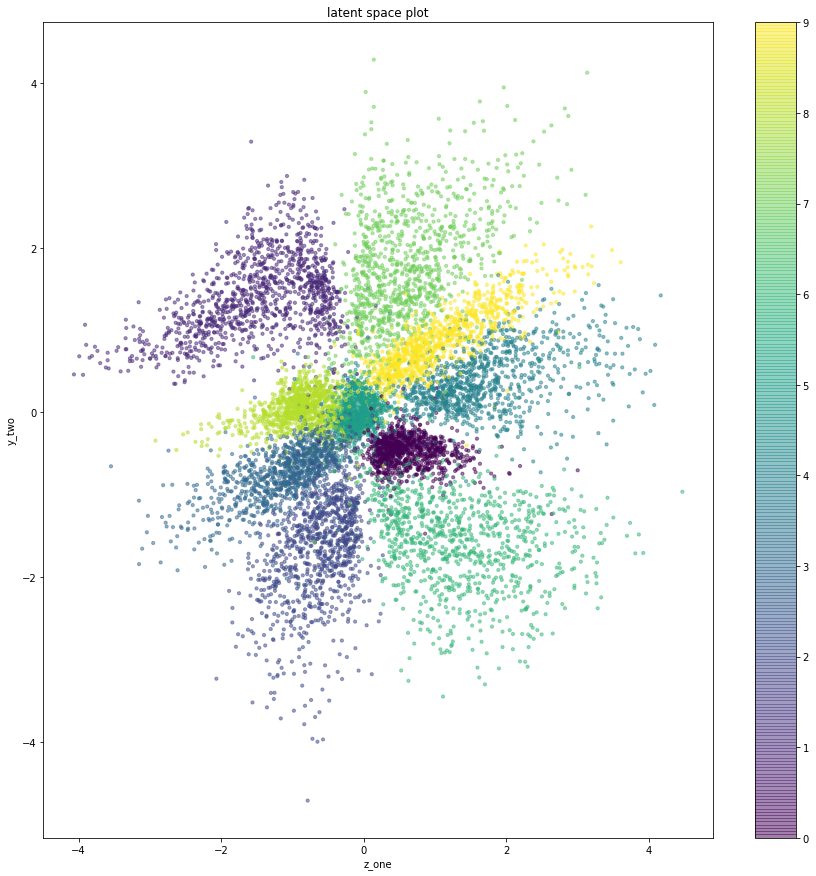

In [42]:
vae_z_2dplot(x_test, y_test, encoder)

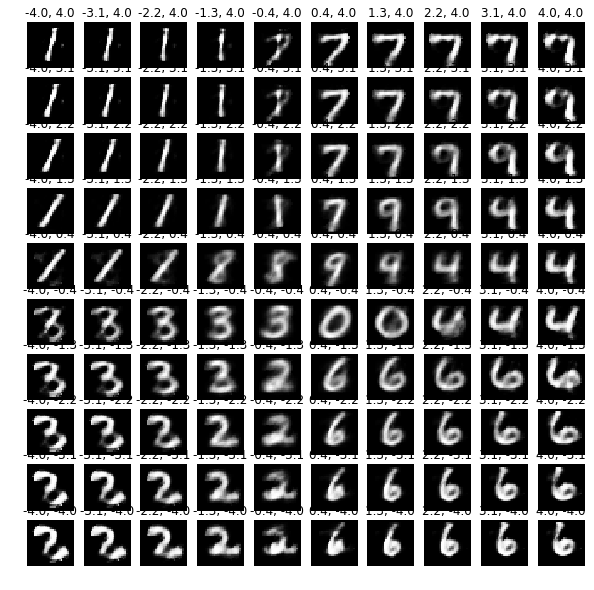

In [43]:
vaedecode_result_2dplot(num_z_one, num_z_two, z_one_linspace, z_two_linspace, decoder)

in the z_mean point cloud, it seems that except the center of the plot, clusters are getting more separated from each other. The boundary of the points of different digits is more clear.